Y_data: 20640
y_data: 19648
y_data: 18665
Best alpha: 0.001
Predicción de precios de casas sin ruido:
MSE: 0.3376051969378297
MAE: 0.4332968333001364
RMSE: 0.5810380339855814
R2: 0.6447444689662328


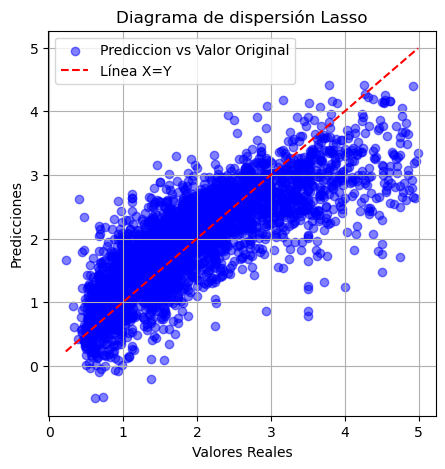


Epsilon = 1e-07
Error del ruido:
MAE: 2801716150572344.0
MAE: 13263457.120659642
RMSE: 52931239.83596402
R2: -1163276403067193.2

Predicción de precios con ruido:
MSE: 0.49318800286885656
MAE: 0.5335188990497625
RMSE: 0.7022734530571809
R2: 0.4810276398354041

Epsilon = 0.0001
Error del ruido:
MAE: 2914285302.6389337
MAE: 13379.087219622794
RMSE: 53984.12083788096
R2: -1210015268.9883118

Predicción de precios con ruido:
MSE: 0.4931912336529647
MAE: 0.5335184608824088
RMSE: 0.7022757532856767
R2: 0.4810242401427026

Epsilon = 0.1
Error del ruido:
MAE: 2809.418463641365
MAE: 13.264070737211405
RMSE: 53.00394762318525
R2: -1165.4744140578503

Predicción de precios con ruido:
MSE: 0.49316947369254677
MAE: 0.5335109861634046
RMSE: 0.7022602606530907
R2: 0.48104713773540453

Epsilon = 0.5
Error del ruido:
MAE: 112.50257092814759
MAE: 2.66536383028394
RMSE: 10.606722911820954
R2: -45.71122234076873

Predicción de precios con ruido:
MSE: 0.4928740485167636
MAE: 0.5333487490016754
RMSE: 0.702

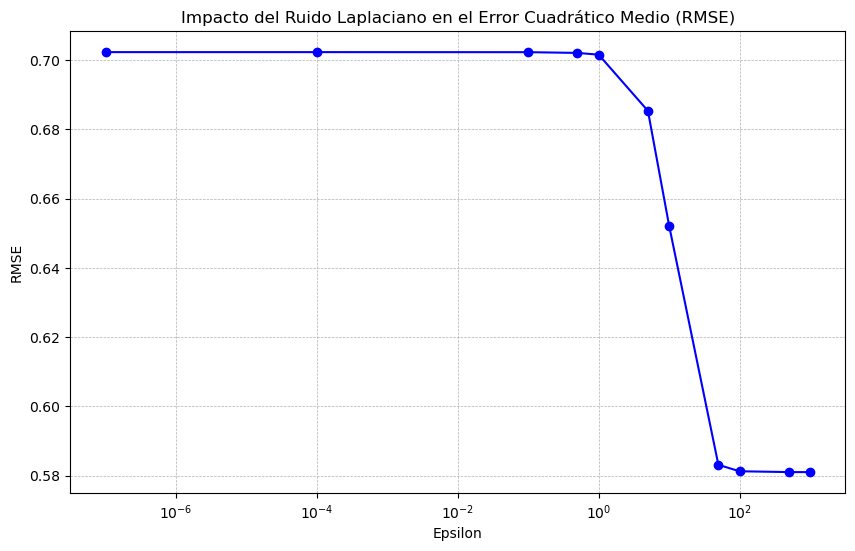

In [22]:
import numpy as np
import ModeloBase
from ModeloBase import read_data_model, add_laplace_noise, rmse
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import Lasso
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

np.random.seed(42) 


all_data = fetch_california_housing()
X_train_val, X_val, X_test, Y_train_val, Y_val, Y_test = read_data_model(all_data, 'MedInc')

# Entrenamos el scanner con los datos train_val para evitar fuga de datos antes del entrenamiento
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hiperparámetros
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
mse1 = []

for i in alpha:
    model_lasso = Lasso(alpha=i, max_iter=10000)
    model_lasso.fit(X_train_val_scaled, Y_train_val)
    Y_predict = model_lasso.predict(X_val_scaled)
    mse1.append(mse(Y_val, Y_predict))

# Seleccion del mejor alpha
best_alpha = alpha[np.argmin(mse1)]
print(f"Best alpha: {best_alpha}")

# Entrenamiento del modelo original sin ruido
model_original = Lasso(alpha = best_alpha, max_iter=10000)
model_original.fit(X_train_val_scaled, Y_train_val)
Y_predict = model_original.predict(X_test_scaled)

# Evaluación del modelo original sin ruido
MSE_original = mse(Y_test, Y_predict)
MAE_original = mae(Y_test, Y_predict)
RMSE_original = rmse(Y_test, Y_predict)
R2_original = r2(Y_test, Y_predict)

print("Predicción de precios de casas sin ruido:")
print(f"MSE: {MSE_original}")
print(f"MAE: {MAE_original}")
print(f"RMSE: {RMSE_original}")
print(f"R2: {R2_original}")

# Diagrama de dispersión de predicciones vs valores originales
plt.figure(figsize=(5, 5))
plt.scatter(Y_test, Y_predict, alpha=0.5, color='blue', label='Prediccion vs Valor Original')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Línea X=Y')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Diagrama de dispersión Lasso')
plt.legend()
plt.grid(True)

# Guardar la imagen antes de mostrarla
plt.savefig('diagrama_dispersion_LASSO.png', dpi=300)
plt.show()


# Iterar sobre diferentes valores de epsilon
epsilon_values = [0.0000001, 0.0001, 0.1, 0.5, 1.0, 5 , 10, 50, 100, 500, 1000]
results = []

for epsilon in epsilon_values:
    print(f"\nEpsilon = {epsilon}")

    # Paso 1: Agregar ruido laplaciano a la columna de ingresos en el conjunto de entrenamiento
    X_train_val_noisy = add_laplace_noise(X_train_val, epsilon)
   
    MSE_original = mse(X_train_val, X_train_val_noisy)
    MAE_original = mae(X_train_val, X_train_val_noisy)
    RMSE_original = rmse(X_train_val, X_train_val_noisy)
    R2_original = r2(X_train_val, X_train_val_noisy)

    print("Error del ruido:")
    print(f"MAE: {MSE_original}")
    print(f"MAE: {MAE_original}")
    print(f"RMSE: {RMSE_original}")
    print(f"R2: {R2_original}")

    # Paso 2: Entrenar el modelo utilizando los valores de ingresos con ruido
    scaler = StandardScaler()
    X_train_val_noisy_scaled = scaler.fit_transform(X_train_val_noisy)
    X_test_scaled = scaler.transform(X_test)

    model_noisy = Lasso(alpha=best_alpha, max_iter=10000)  # Aumentar el número de iteraciones
    model_noisy.fit(X_train_val_noisy_scaled, Y_train_val)
    Y_predict = model_noisy.predict(X_test_scaled)

    # Paso 3: Evaluar el modelo entrenado con datos ruidosos usando el conjunto de validación original
    MSE_noisy = mse(Y_test, Y_predict)
    MAE_noisy = mae(Y_test, Y_predict)
    RMSE_noisy = rmse(Y_test, Y_predict)
    R2_noisy = r2(Y_test, Y_predict)

    print("\nPredicción de precios con ruido:")
    print(f"MSE: {MSE_noisy}")
    print(f"MAE: {MAE_noisy}")
    print(f"RMSE: {RMSE_noisy}")
    print(f"R2: {R2_noisy}")

    results.append((epsilon,MSE_noisy ,MAE_noisy, RMSE_noisy, R2_noisy))

# Mostrar los resultados
import pandas as pd
results_df = pd.DataFrame(results, columns=["Epsilon", "MSE","MAE", "RMSE", "R2"])
print(results_df)

# Graficar el RMSE en función del valor de epsilon
plt.figure(figsize=(10, 6))
plt.plot(results_df["Epsilon"], results_df["RMSE"], marker='o', linestyle='-', color='blue')
plt.xscale('log')  # Usar escala logarítmica para epsilon
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('Impacto del Ruido Laplaciano en el Error Cuadrático Medio (RMSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('Lasso_rmse_vs_epsilon.png', dpi=300)
plt.show()
